In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import random
import importlib
import mpt_functions as mpt
importlib.reload(mpt)

<module 'mpt_functions' from 'd:\\Code\\Graduation-Project\\mpt_functions.py'>

In [129]:
path = "C:/Users/bilge/Downloads/Group_14_Clean_Data.csv"
df = mpt.get_the_data_and_convert_datetime(path)
df = mpt.drop_a_column(df, "Unnamed: 0")
df.head()

,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,status
0,2020-04-18 00:00:01,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1
1,2020-04-18 00:00:13,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1
2,2020-04-18 00:00:24,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1
3,2020-04-18 00:00:36,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2020-04-18 00:00:49,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1


In [130]:
df_day1 = mpt.filter_a_day("2020-03-01", df)  
df_minute = mpt.aggregate_as_a_minute(df_day1)

# Ensure timestamp is datetime and set as index
df_minute['timestamp'] = pd.to_datetime(df_minute['timestamp'])
df_minute = df_minute.set_index('timestamp')

# Select DV_pressure and resample per second
df_pressure = df_minute[['DV_pressure']]

# Downsample to 1-minute intervals
df_resampled = df_pressure.resample('1T').mean().dropna()

In [131]:
df_resampled.head()

,DV_pressure
timestamp,
2020-03-01 04:00:00,-0.026
2020-03-01 04:04:00,-0.026
2020-03-01 04:05:00,-0.026
2020-03-01 04:09:00,-0.022
2020-03-01 04:13:00,-0.026


In [132]:
# Augmented Dickey-Fuller test for stationarity
adf_test = adfuller(df_resampled)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
if adf_test[1] > 0.05:
    print("Data is non-stationary. Differencing needed.")
    df_resampled = df_resampled.diff().dropna()

ADF Statistic: -11.977802066364049
p-value: 3.765940682494073e-22


In [133]:
df_resampled.head()

,DV_pressure
timestamp,
2020-03-01 04:00:00,-0.026
2020-03-01 04:04:00,-0.026
2020-03-01 04:05:00,-0.026
2020-03-01 04:09:00,-0.022
2020-03-01 04:13:00,-0.026


In [134]:
print(df_resampled.columns)

Index(['DV_pressure'], dtype='object')


In [140]:
df_resampled.shape

(145, 1)

In [154]:
df_resampled.index = pd.to_datetime(df_resampled.index)

# Drop any rows with NaN values
df_resampled = df_resampled.dropna()

# Define the hour range for forecasting
forecast_hour_start = pd.Timestamp("2020-03-01 00:00:00")  # Start of the hour
forecast_hour_end = pd.Timestamp("2020-03-01 12:00:00")    # End of the hour

# Slice the data for the specified hour
df_hour = df_resampled[(df_resampled.index >= forecast_hour_start) & (df_resampled.index < forecast_hour_end)]

# Print the shape and head of the resulting DataFrame
print("Hourly Data Shape:", df_hour.shape)
print(df_hour.head(12))

Hourly Data Shape: (64, 1)
                     DV_pressure
timestamp                       
2020-03-01 04:00:00       -0.026
2020-03-01 04:04:00       -0.026
2020-03-01 04:05:00       -0.026
2020-03-01 04:09:00       -0.022
2020-03-01 04:13:00       -0.026
2020-03-01 04:15:00       -0.026
2020-03-01 04:43:00       -0.024
2020-03-01 04:46:00       -0.026
2020-03-01 04:47:00       -0.024
2020-03-01 05:11:00       -0.025
2020-03-01 05:21:00       -0.026
2020-03-01 05:24:00       -0.026


In [172]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model (example)
model = ARIMA(df_hour['DV_pressure'], order=(2, 1, 2))  # Replace with your target column
model_fit = model.fit()

# Forecast the next 10 minutes
forecast = model_fit.forecast(steps=10)
print("Forecast for the next 10 minutes:", forecast)

Forecast for the next 10 minutes: 64   -0.023472
65   -0.023345
66   -0.023386
67   -0.023366
68   -0.023376
69   -0.023371
70   -0.023373
71   -0.023372
72   -0.023373
73   -0.023373
Name: predicted_mean, dtype: float64


d:\Anaconda\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [166]:
from pmdarima import auto_arima
auto_arima(df_hour['DV_pressure']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   64
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 330.550
Date:                Thu, 20 Mar 2025   AIC                           -655.101
Time:                        22:48:13   BIC                           -648.672
Sample:                             0   HQIC                          -652.572
                                 - 64                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.473e-05   2.61e-05      1.331      0.183   -1.64e-05    8.59e-05
ma.L1         -0.8742      0.071    -12.328      0.000      -1.013      -0.735
sigma2       1.57e-06   2.98e-07      5.264      0.000    9.85e-07    2.15e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                 5.11
Prob(Q):                              0.51   Prob(JB):                         0.08
Heteroskedasticity (H):               1.24   Skew:                             0.70
Prob(H) (two-sided):                  0.63   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

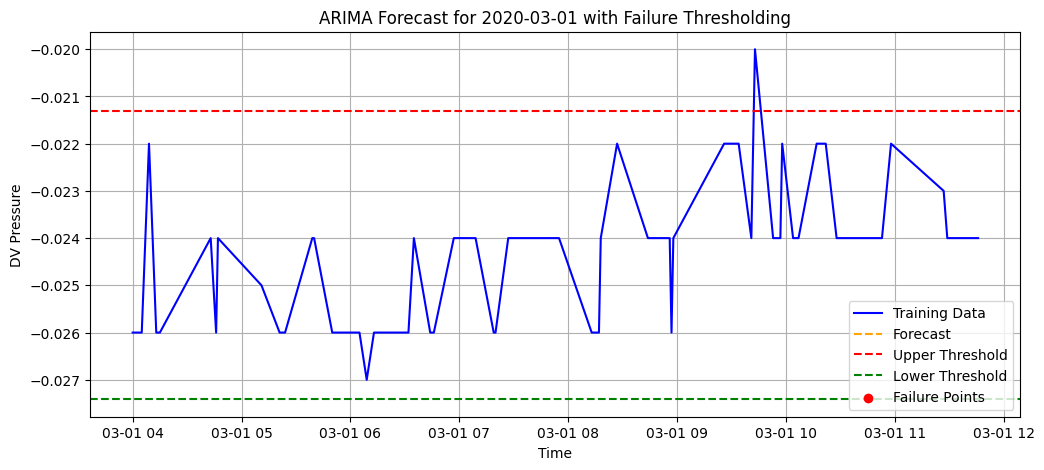

In [170]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate thresholds for DV_pressure
upper_threshold = df_hour['DV_pressure'].mean() + 2 * df_hour['DV_pressure'].std()
lower_threshold = df_hour['DV_pressure'].mean() - 2 * df_hour['DV_pressure'].std()

forecast_index = pd.date_range(start=df_hour.index[-1] + pd.Timedelta(minutes=1),
                               periods=len(forecast), freq='T')
forecast = pd.Series(forecast, index=forecast_index)

# Identify failure points
failure_points = forecast[(forecast > upper_threshold) | (forecast < lower_threshold)]

# Plot results
plt.figure(figsize=(12, 5))
plt.plot(df_hour.index, df_hour['DV_pressure'], label='Training Data', color='blue')
plt.plot(forecast.index, forecast, label='Forecast', color='orange', linestyle='dashed')
plt.axhline(upper_threshold, color='red', linestyle='dashed', label='Upper Threshold')
plt.axhline(lower_threshold, color='green', linestyle='dashed', label='Lower Threshold')
plt.scatter(failure_points.index, failure_points, color='red', label='Failure Points', zorder=3)
plt.legend()
plt.title("ARIMA Forecast for 2020-03-01 with Failure Thresholding")
plt.xlabel("Time")
plt.ylabel("DV Pressure")
plt.grid(True)
plt.show()